# Statistic for AI and Data Science - Coursework 3

     
 1. Task 1: Changes in Property Prices
     1. Calculate and Display Price Changes
     1. Statistical Analysis
     1. Discussion
 1. Task 2: Storks Deliver Babies
     1. Implementation of Two Regression Models for the Number of Births
     1. Use of Bootstrapping to Compare the Models
     1. Discussion

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

## Task 1: Changes in Property Prices

Using data provided by the ONS containing information on the average property prices for a 36 month period, our goal is to test for independence between price changes and the region to which these price changes belong.

### 1A: Calculate and Display Price Changes

See the first five rows of our data below.

In [8]:
prices = pd.read_csv('average_flat_prices.csv')
prices.head()

,Area,Code,Price,Month,RegionName,RegionCode
0,Hartlepool,E06000001,62078.20672,2016-09-01,North East,E12000001
1,Hartlepool,E06000001,61893.84174,2016-10-01,North East,E12000001
2,Hartlepool,E06000001,61909.33647,2016-11-01,North East,E12000001
3,Hartlepool,E06000001,62919.44401,2016-12-01,North East,E12000001
4,Hartlepool,E06000001,60770.80795,2017-01-01,North East,E12000001


We are conerned with calculating the price changes for all areas between July 2017 and July 2018. Therefore we start by filtering our dataframe to only include those rows whose 'Month' column corresponds to July 2017 and July 2018. The subequent cell merges these two dataframes and creates a new column, 'Price_Differece', computed by taking the difference between the prices in July 2018 and the prices in July 2017.

In [10]:
prices_2017 = prices.loc[prices['Month'] == '2017-07-01']
prices_2017.set_index('Area', inplace=True)

prices_2018 = prices.loc[prices['Month'] == '2018-07-01']
prices_2018.set_index('Area', inplace=True)

In [11]:
prices_compared = pd.merge(prices_2017[['Price']], prices_2018[['Price']], 
                           left_index=True, right_index=True)
prices_compared.rename(columns={'Price_x': 'Price_2017', 'Price_y': 'Price_2018'}, inplace=True)

prices_compared = prices_compared.assign(Price_Difference=prices_compared['Price_2018'] - prices_compared['Price_2017'])
prices_compared

,Price_2017,Price_2018,Price_Difference
Area,,,
Hartlepool,65007.84170,61116.82158,-3891.02012
Middlesbrough,69163.06963,69313.90788,150.83825
Redcar and Cleveland,65507.80990,64802.79724,-705.01266
Stockton-on-Tees,83599.32806,83654.55272,55.22466
Darlington,87041.37973,83679.31818,-3362.06155
...,...,...,...
Suffolk,140278.18370,142488.46480,2210.28110
Surrey,270116.52610,267144.69100,-2971.83510
Warwickshire,165676.94800,167470.71860,1793.77060


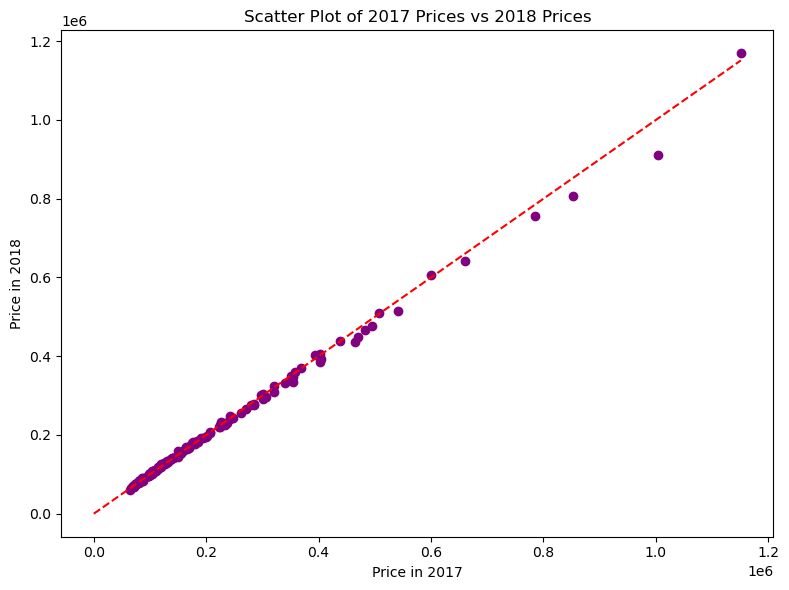

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(prices_compared['Price_2017'], prices_compared['Price_2018'], color='purple')
plt.title('Scatter Plot of 2017 Prices vs 2018 Prices')
plt.xlabel('Price in 2017')
plt.ylabel('Price in 2018')

plt.plot([0, prices_compared['Price_2017'].max()], [0, prices_compared['Price_2017'].max()], color='red', linestyle='--')

plt.tight_layout()
plt.show()


The plot above is of property prices in 2017 against property prices in 2018. The dashed, red line has the equation Price_2017 = Price_2018. A deviation from this line indicates a price change between July 2018 and July 2017. The graph appears to indicate that (a) more regions have their average property price decrease than increase and (b) that decreases in property price are of a greater magnitude than increases.

In [14]:
price_increase_count = (prices_compared['Price_Difference'] > 0).sum()
price_decrease_count = (prices_compared['Price_Difference'] < 0).sum()

print(f"Number of areas where price has gone up: {price_increase_count}")
print(f"Number of areas where price has gone down: {price_decrease_count}")

Number of areas where price has gone up: 74
Number of areas where price has gone down: 77


The output of the cell above, in fact, shows that there is not a large difference in the number of regions whose average property prices have increases vs those regions whose prices have decreased.

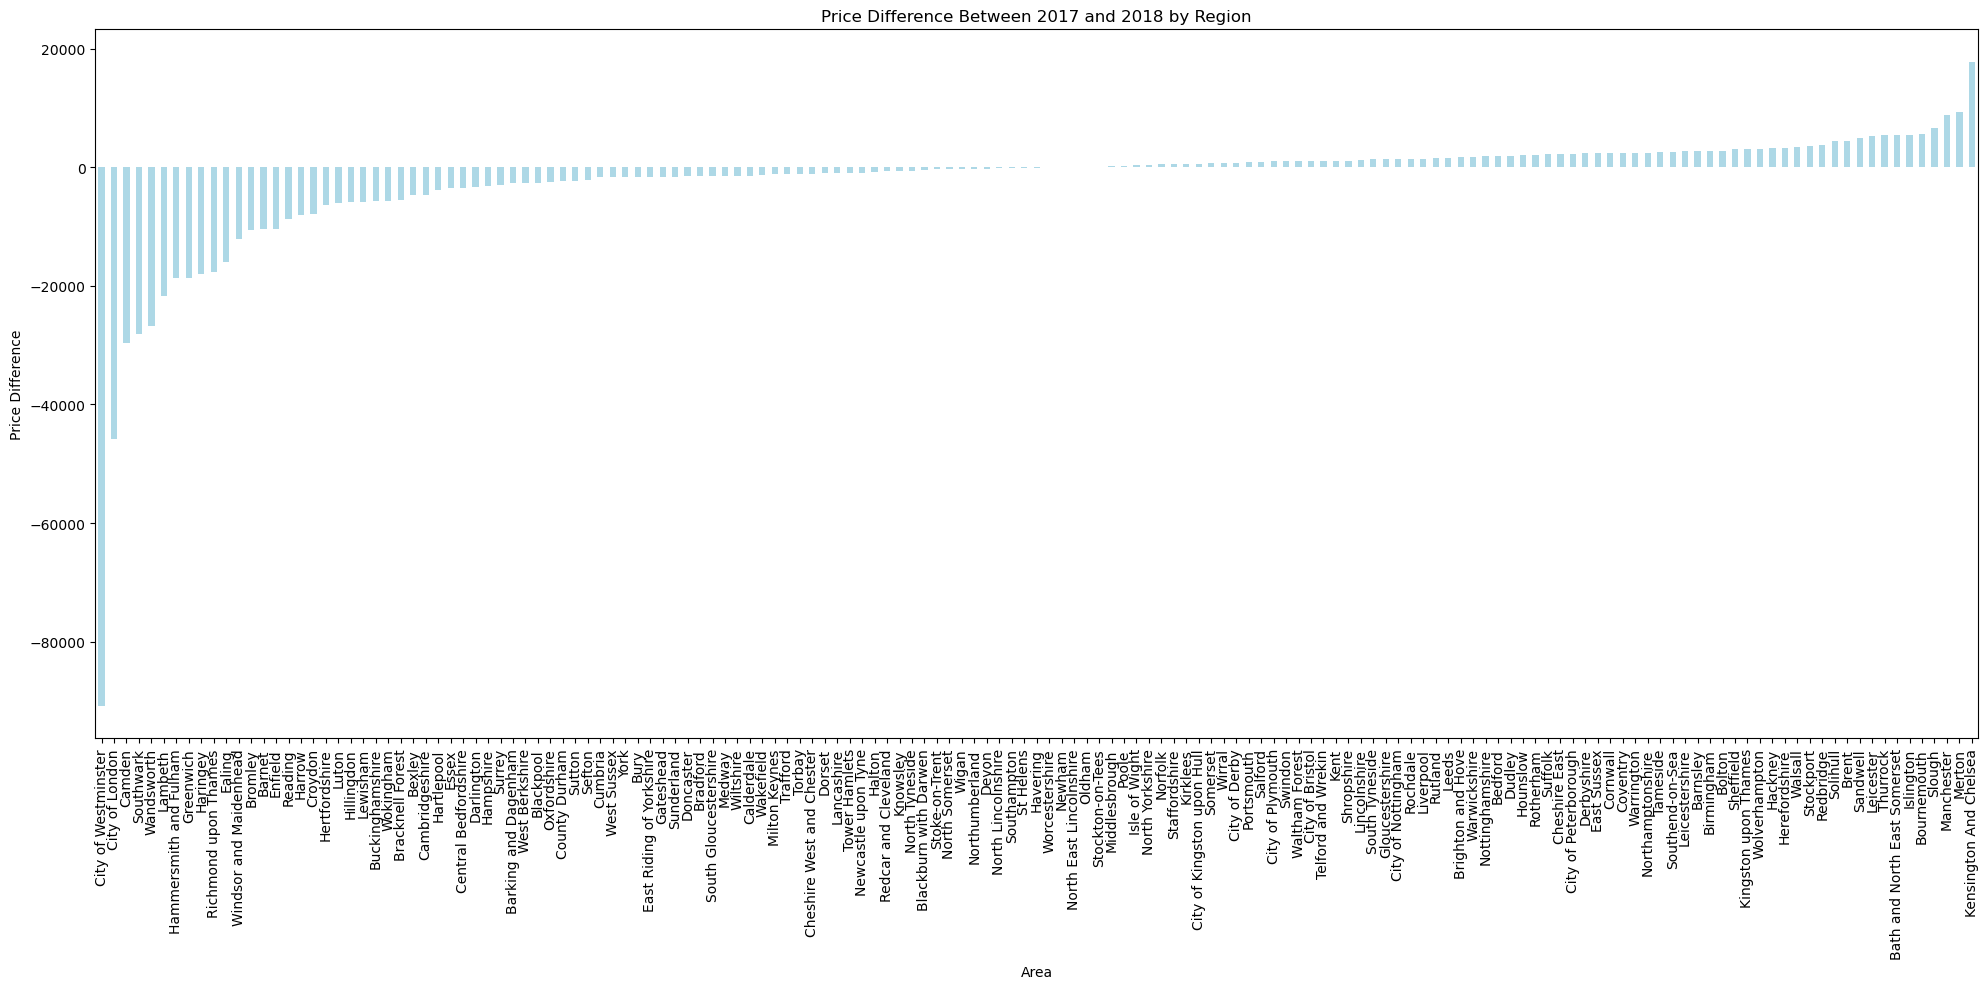

In [16]:
prices_compared_sorted = prices_compared.sort_values('Price_Difference', ascending=True)

plt.figure(figsize=(20, 10))
prices_compared_sorted['Price_Difference'].plot(kind='bar', color='lightblue')
plt.title('Price Difference Between 2017 and 2018 by Region')
plt.xlabel('Area')
plt.ylabel('Price Difference')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


The above plot is a bar graph of area against price change. All 151 areas in our dataset are within the graph. Our first suspicion, that decreases in price greatly outweight increases in price, is confirmed by this graph.

The below two graphs 'zoom in' on the two 'tails' of our graph - showing the top ten areas with the greatest price increase and the top ten areas with the greatest price decrease.

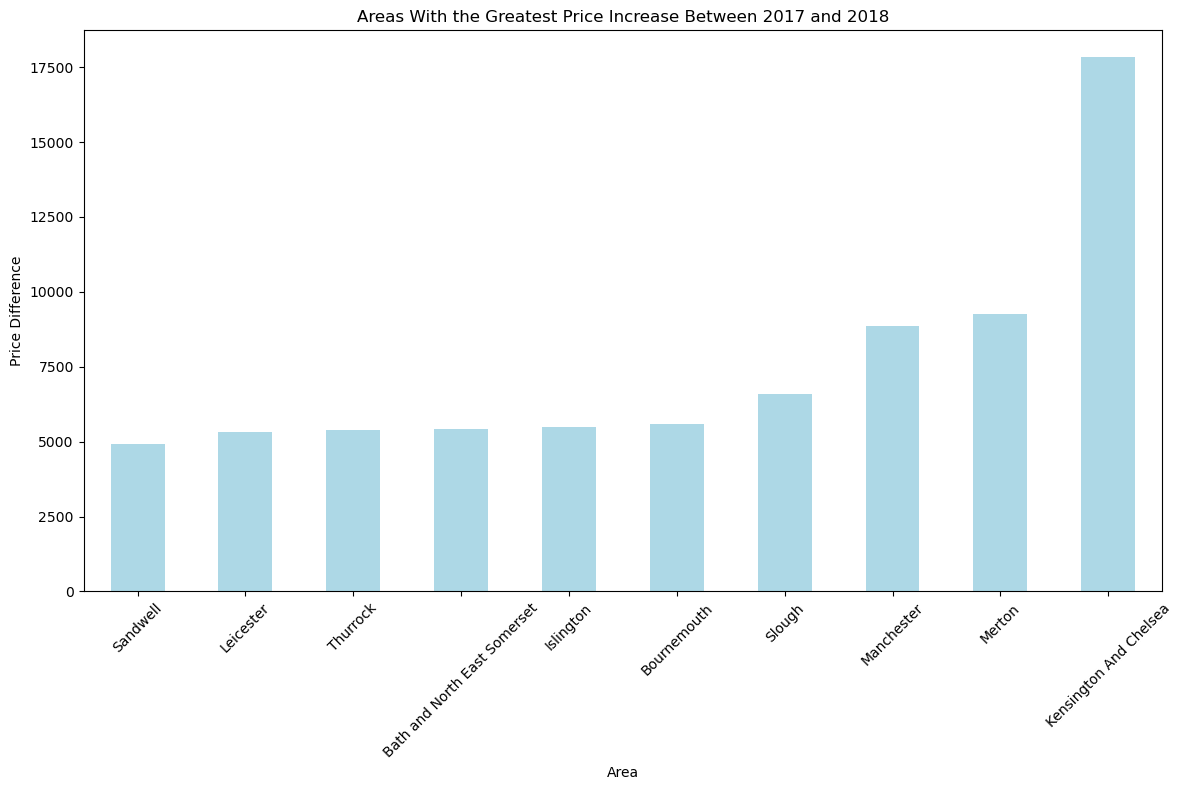

In [18]:
top_10_price_diff = prices_compared_sorted.tail(10)

plt.figure(figsize=(12, 8))
top_10_price_diff['Price_Difference'].plot(kind='bar', color='lightblue')
plt.title('Areas With the Greatest Price Increase Between 2017 and 2018')
plt.xlabel('Area')
plt.ylabel('Price Difference')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


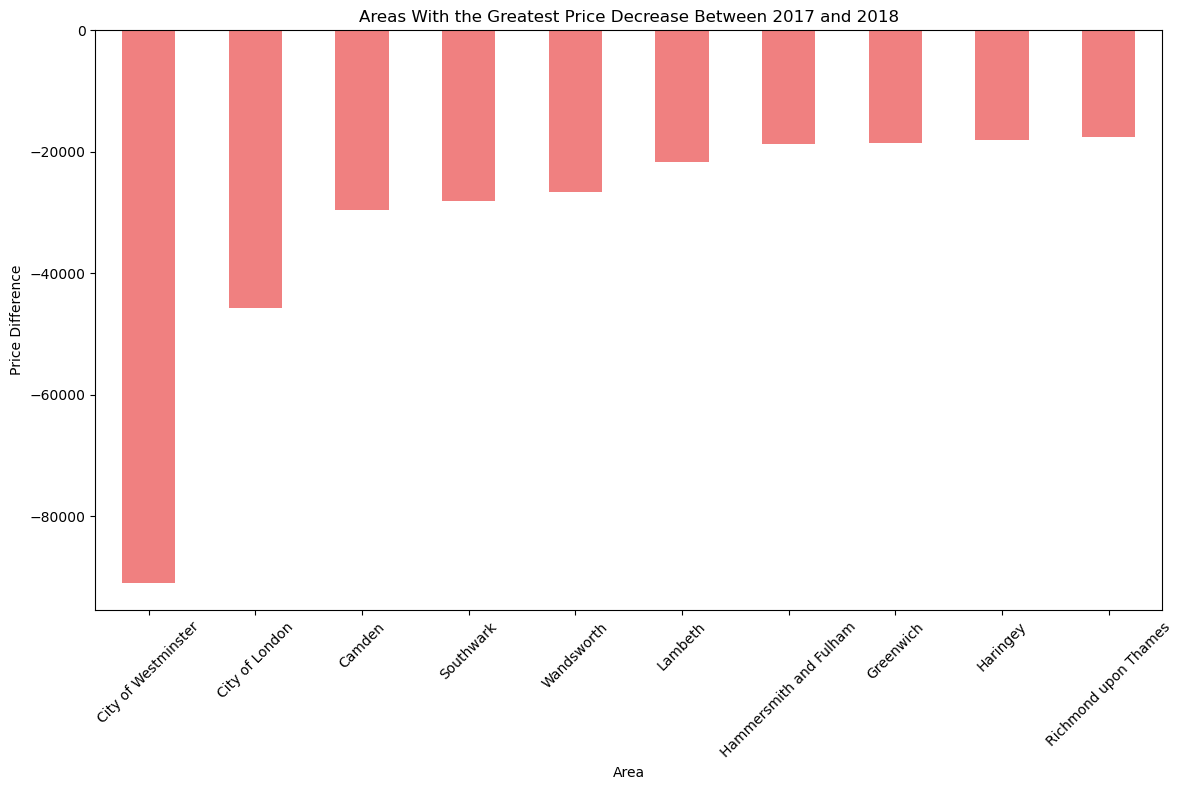

In [19]:
bottom_10_price_diff = prices_compared_sorted.head(10)

plt.figure(figsize=(12, 8))
bottom_10_price_diff['Price_Difference'].plot(kind='bar', color='lightcoral')
plt.title('Areas With the Greatest Price Decrease Between 2017 and 2018')
plt.xlabel('Area')
plt.ylabel('Price Difference')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We have thus far focused solely price changes within local areas, as opposed to price changes within larger, geographical regions. The ONS recognises a total of 9 regions in England and each region is composed of many areas. As can be seen from the first 5 lines of our dataset above, a column called 'RegionName' helps to identify the region an area belongs to.

In order to calculate the average price change within each region, we essentially group together data on areas in the same region, sum their total price change and divide it by the number of areas in each region. The plot below displays the average price change per region.

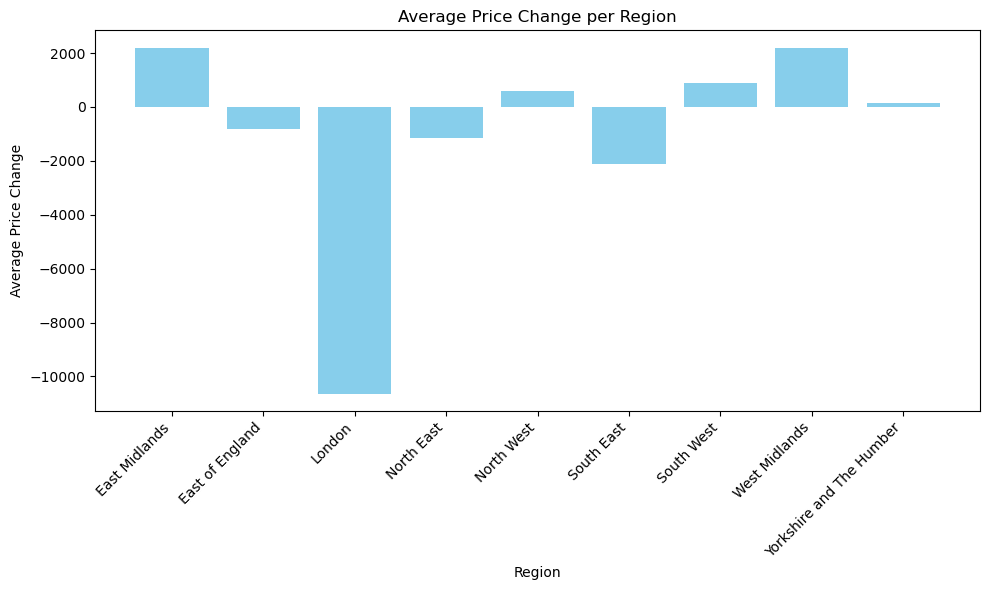

In [21]:
prices_unique = prices.drop_duplicates(subset=['Area'])

merged_df = prices_compared.reset_index().merge(prices_unique[['Area', 'RegionName']], on='Area', how='left')

merged_df['Change'] = merged_df['Price_Difference'].apply(lambda x: 'Increase' if x > 0 else 'Decrease')

region_summary = merged_df.groupby('RegionName').agg(
    total_price_change=('Price_Difference', 'sum'),
    area_count=('RegionName', 'size')
).reset_index()

region_summary['average_price_change'] = region_summary['total_price_change'] / region_summary['area_count']

avg_price_change_df = region_summary[['RegionName', 'average_price_change']]

plt.figure(figsize=(10, 6))
plt.bar(avg_price_change_df['RegionName'], avg_price_change_df['average_price_change'], color='skyblue')
plt.title('Average Price Change per Region')
plt.xlabel('Region')
plt.ylabel('Average Price Change')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Without a broader understanding of the economic, political and market-specific factors influencing property prices between July 2017 and July 2018, not much can be commented on on the above graph. 

We can stipulate that: London being a region with notoroiously high property prices, many buyers may have been put off by the prices, choosing instead to live elsewhere. A mass-scale event such as this would lead to a decrease in house prices in the London region, and increases in house prices in other regions. 

We should note that Brexit negotiations between the UK and EU began in June 2017. London, being the financial hub of the UK, may have been disproportionately affected by concerns over the UK's future relationship with the EU.

### 1B: Statistical Analysis

Our goal in this section is to perform a chi-squared and permutation test to check for independence between region and price changes.

We start by cross tabulating our data by counting the number of areas in each region whose average property price increases and decreases. The table below contains our results.




In [25]:
final_df = merged_df[['Area', 'RegionName', 'Change']]
final_df.columns = ['Area', 'Region', 'Change']

cross_tab = pd.crosstab(final_df['Region'], final_df['Change'])

cross_tab

Change,Decrease,Increase
Region,,
East Midlands,0,9
East of England,5,6
London,23,10
North East,9,3
North West,12,11
South East,13,6
South West,6,9
West Midlands,2,12
Yorkshire and The Humber,7,8


As with any hypothesis tests, we need to first find our null and alternative hypothesis. A cursory glance at the table above indicates that there is an association between region and price changes. Our two hypotheses are thus:

$H_0$ : There is no association between the region and whether property prices increased or decreases between June 2017 and June 2018 (that the two are independent).

$H_1$ : There is an association between region and property prices (the two are not independent).

In [27]:
test_stat, p_value, dof, expected = stats.chi2_contingency(cross_tab, correction=False, 
                                                           lambda_ = "log-likelihood")
expected

array([[ 4.58940397,  4.41059603],
       [ 5.60927152,  5.39072848],
       [16.82781457, 16.17218543],
       [ 6.1192053 ,  5.8807947 ],
       [11.72847682, 11.27152318],
       [ 9.68874172,  9.31125828],
       [ 7.64900662,  7.35099338],
       [ 7.13907285,  6.86092715],
       [ 7.64900662,  7.35099338]])

Assuming our null hypothesis - that region and price changes are independent of one another - our cross tabulated data ought to look similar to the above array. It clearly does not, and so the two are likely independent.

The cell below outputs the relavent metrics for our test. A discussion of our results is contained in the next subsection.

In [29]:
print(f"Chi-square Statistic: {test_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi-square Statistic: 32.19006315529839
P-value: 8.611576591190181e-05
Degrees of Freedom: 8


We now do a permutation test. To reflect the differences in test-approach, our null and alternative hypotheses are different to those in the chi-squared test (an explanation of their differences is contained in the next section).

$H_0$ : Price differences between the regions are due to random chance (region has no effect on price).

$H_0$ : Price differences between regions are not due to chance and, instead, reflect a real effect.

Again, we withold discussion on our results until the next subsection.

In [31]:
observed_mean_diff = prices_compared['Price_2017'].mean() - prices_compared['Price_2018'].mean()
num_permutations = 10000
permutation_diffs = []

for _ in range(num_permutations):
    shuffled_prices = prices_compared['Price_2017'].sample(frac=1, replace=False).reset_index(drop=True)
    permuted_diff = shuffled_prices - prices_compared['Price_2018']
    permutation_diffs.append(permuted_diff.mean())

permutation_diffs = np.array(permutation_diffs)

p_value = np.mean(np.abs(permutation_diffs) >= np.abs(observed_mean_diff))

print(f"Observed Mean Price Difference: {observed_mean_diff}")
print(f"P-value from Permutation Test: {p_value}")

Observed Mean Price Difference: 2217.1960365562118
P-value from Permutation Test: 0.0


### 1C: Discussion

Both the chi-squared and permutation test aimed to test whether region and price changes are independent. 

For the chi-squared test, we assumed the null hypothesis, that region and price changes were independent. The null hypothesis allowed us to construct the expected distribution of price changes, seen in the output of cell 27. We then used the expected and observed values to calculate our test statistic, the G-statistic. The G-statistic was then used to deduce the probability of observing results as or more extreme than our observations. Our returned P-value of $8.6 \times 10^5$ tells us the probability of receiving results as or more extreme than ours. As this value is markedly different to the 'normal' critical values used, i.e., 1% (0.01) or 5% (0.005), we have reason to reject our null hypothesis. Region and price differences do not appear to be independent.

The permutation test is done differently. First, the average price difference between July 2018 and July 2017 was computed, giving a value of £2217. We then randomly shuffled the average property prices in July 2017 a total of 10,000 times, computing the mean difference between values in the unshuffled July 2018 column and the shuffled July 2017 column. This random shuffling simulates the null hypothesis, that there is no real difference between the prices of the two years. The P-value of a permutation test is given by the proportion of permutations where the mean difference is as or more extreme than the observed mean difference of £2217. We received a P-value of 0 - indicating that not a single permutation yielded a difference as extreme as ours. Again, in line with our discussion above on critical values, we are forced to reject our null hypothesis. Region and price differences do not appear to be independent.

Though both tests reach the same conclusion, the chi-squared test is based on a statistical comparison between observed and expected frequences, whilst the permutation test is based on resampling and simulating the null hypothesis. As with other parametric tests, the chi-squared test requires a distribution (obtained by assuming the null hypothesis), and the P-value is measured with respect to this distribution. The permutation test, however, does not assume a specific distribution and relies purely on the data, making it a more flexible approach.

## Task 2: Storks Deliver Babies

The purpose of this section is to construct two regression models based on data found in *Robert Matthews. “Storks Deliver Babies (p = 0.008)”. Teaching Statistics. Volume 22,
Number 2, Summer 2000, p36-8*  .The purpose of the paper is to provide yet more support for the idea that correlation does not equal causation. The author of the paper constructs a regression model between the number of white stork pairs (a bird) in a country and the country's birthrate. We construct the very same model as the author (model 1), as well as a multiple regression model (model 2), which we hope will perform better than model 1.

### 2A: Implementation of Two Regression Models for the Number of Births

See the first five rows of our data below. Again, our goal is to create two regression models. The target variable is the same for both - the number of births, or 'BirthRate'. The first model will have a singular predictor variable, the number of stork pairs, or 'Storks'. The second model will have three predictors, the population size in millions ('Humans'), the GDP per capita and the population density.

In [38]:
data = pd.read_csv('modified_stork_data.csv')
data.head()

,Country,Area,Storks,Humans,BirthRate,GDP_per_capita,PopDensity
0,Albania,28750,100,3.2,83,3983,0.1113
1,Austria,83860,300,7.6,87,26930,0.0906
2,Belgium,30520,1,9.9,118,27412,0.3244
3,Bulgaria,111000,5000,9.0,117,8922,0.0811
4,Denmark,43100,9,5.1,59,29412,0.1183


One can see that our four total predictor variables exist at different scales. A necessary step in our model construction will therefore be to standardise the variables.

We start first by constructing a regression model between 'Storks' and 'BirthRate'.

Intercept: 370.706
Slope (Standardised Coefficient for Storks): 246.744
R² (Coefficient of Determination): 0.385


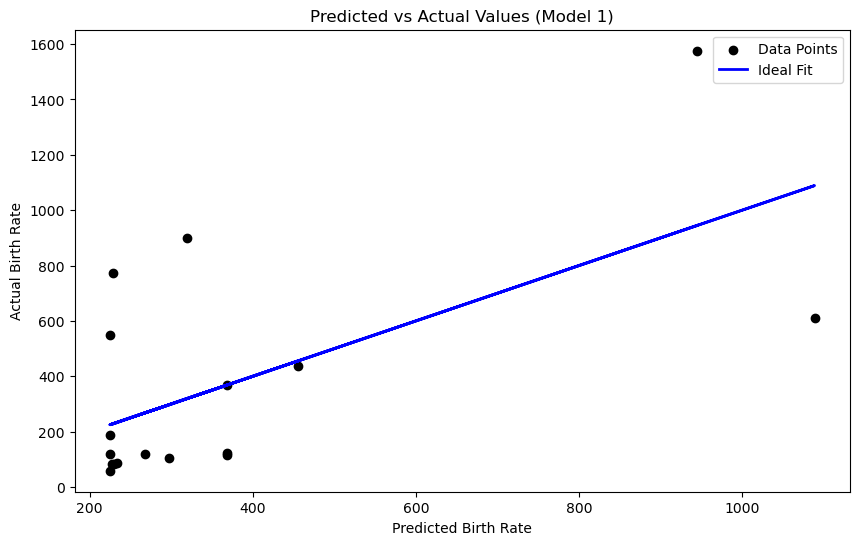

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('modified_stork_data.csv')

X1 = data[['Storks']]  # Predictor
y1 = data['BirthRate']  # Target
scaler1 = StandardScaler()
X1_standardised = scaler1.fit_transform(X1)
model1 = LinearRegression()
model1.fit(X1_standardised, y1)

intercept1 = model1.intercept_
slope1 = model1.coef_[0]
r_squared1 = model1.score(X1_standardised, y1)

print(f"Intercept: {intercept1:.3f}")
print(f"Slope (Standardised Coefficient for Storks): {slope1:.3f}")
print(f"R² (Coefficient of Determination): {r_squared1:.3f}")

predictions1 = model1.predict(X1_standardised)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(predictions1, y1, color='black', label="Data Points")
ax.plot(predictions1, predictions1, color='blue', linewidth=2, label="Ideal Fit")
ax.set_xlabel("Predicted Birth Rate")
ax.set_ylabel("Actual Birth Rate")
ax.set_title("Predicted vs Actual Values (Model 1)")
ax.legend()
plt.show()

The above plot is of predicted birth rate, as per our model, against the actual birth rate as given by our data. While two points fit either exactly on or close to our model's line, the other points appear distant. 

The above cell outputs an important metric for our concerns, the coefficient of determination, or $R^2$. The author of *Storks Deliver Babies* fails to mention this metric, choosing instead to focus entirely on the correlation coefficient, $r$, which in the case of linear regression is merely the square root of $R^2$. $r$ only measures the strength and direction of a linear relationship, whilst $R^2$ measures the proportion of variance in our target variable that can be explained by our predictor. A coefficient of determination value of 0.385 indicates that over 60% of the variability in our target variable (birth rate) *cannot* be explained by variability in our predictor (the number of stork pairs). Additionally, we find in our output a 'Standardised Coefficient for Storks', which is the beta coefficient belonging to our predictor. A value of 246.744 indicates, first, a positive correlation between number of stork pairs and the birthrate in a country. Second, the magnitude of the coefficient tells us that for each standard deviation increase in our predictor, we expect our target variable to increment by 246.744.

We now move onto our second model.



Model 2 (Multiple Predictors):
Intercept: 370.706
Coefficient for Humans: 344.304
Coefficient for GDP_per_capita: -74.920
Coefficient for PopDensity: -22.654
R² (Coefficient of Determination): 0.774


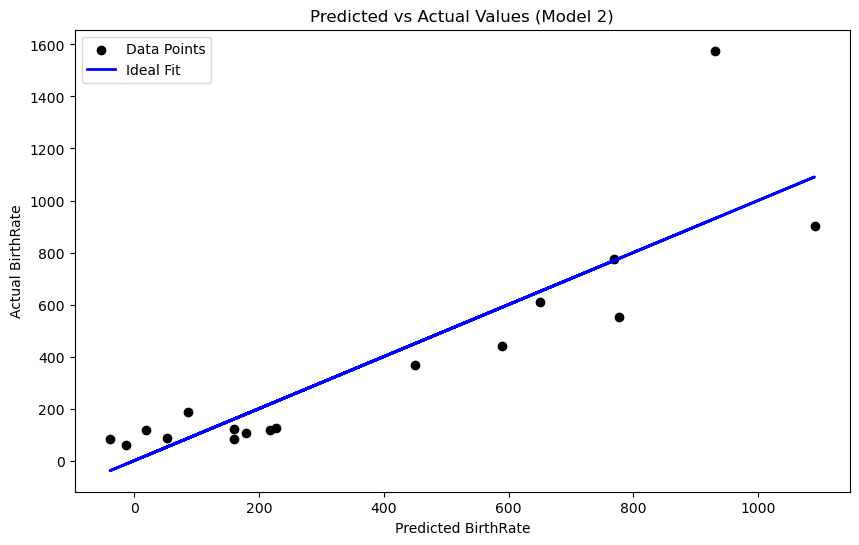

In [42]:
predictors2 = ['Humans', 'GDP_per_capita', 'PopDensity']
target2 = 'BirthRate'
scaler2 = StandardScaler()
data[predictors2] = scaler2.fit_transform(data[predictors2])
X2 = data[predictors2]  # Predictors for Model 2
y2 = data[target2]      # Target variable
model2 = LinearRegression()
model2.fit(X2, y2)

coefficients2 = model2.coef_
intercept2 = model2.intercept_
r_squared2 = model2.score(X2, y2)

print("Model 2 (Multiple Predictors):")
print(f"Intercept: {intercept2:.3f}")
for i, predictor in enumerate(predictors2):
    print(f"Coefficient for {predictor}: {coefficients2[i]:.3f}")
print(f"R² (Coefficient of Determination): {r_squared2:.3f}")

predictions2 = model2.predict(X2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(predictions2, y2, color='black', label="Data Points")
ax.plot(predictions2, predictions2, color='blue', linewidth=2, label="Ideal Fit")
ax.set_xlabel("Predicted BirthRate")
ax.set_ylabel("Actual BirthRate")
ax.set_title("Predicted vs Actual Values (Model 2)")
ax.legend()
plt.show()

See a plot of predicted versus actual birthrate for our model. Model 2 clearly appears to perform better than model 1 due to the relative closeness between the data points and the line generated by our model.

The sign and magnitude of the three predictor coefficients, again, tell us the direction and 'strength' of the relationship between our predictors and target. In the case of our predictor 'Humans', a coefficient of 344 tells us that for each standard deviation increase in the number of 'Humans', the birthrate increases by a value of 344. Birth rate, instead, decreases for increases in GDP per capita and population density.

More importantly the coefficient of determination has a value of 0.774. This tells us that only 22.6% of the variability in our target is attributable to causes *other* than our predictors. Model 2 appears to be a better fit to our data.

### 2B: Use of Bootstrapping to Compare the Models

We now make use of bootstrapping to estimate confidence intervals. We leave off discussion on the methodology of bootstrapping and the significance of our results to the next subsection.

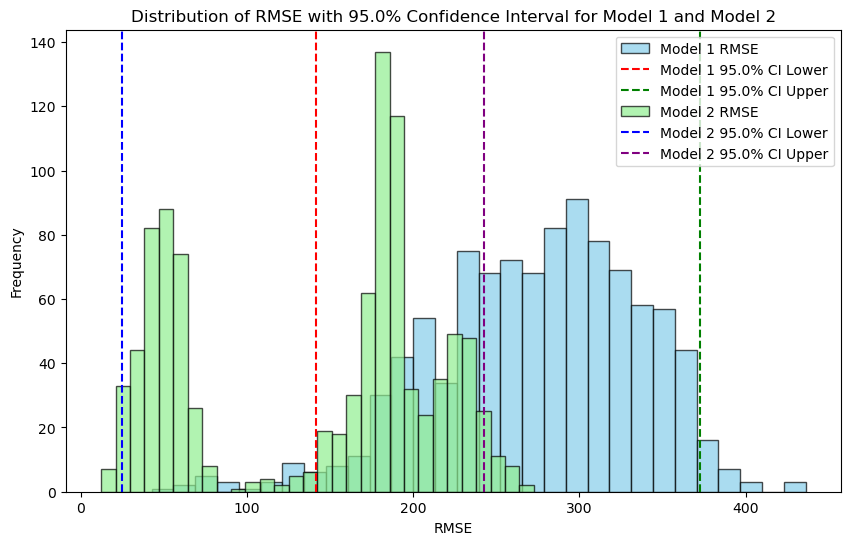

95% Confidence Interval for RMSE of Model 1: (141.280, 372.246)
95% Confidence Interval for RMSE of Model 2: (24.862, 242.713)


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

def bootstrap_rmse(X1, y1, X2, y2, model1, model2, n_iterations=1000, alpha=0.95):
    rmse_model1 = []
    rmse_model2 = []
    
    for i in range(n_iterations):
        X1_resampled, y1_resampled = resample(X1, y1, n_samples=len(X1), random_state=i)
        X2_resampled, y2_resampled = resample(X2, y2, n_samples=len(X2), random_state=i)
        
        model1.fit(X1_resampled, y1_resampled)
        model2.fit(X2_resampled, y2_resampled)
        
        rmse_model1.append(np.sqrt(mean_squared_error(y1_resampled, model1.predict(X1_resampled))))
        rmse_model2.append(np.sqrt(mean_squared_error(y2_resampled, model2.predict(X2_resampled))))
    
    lower_model1 = np.percentile(rmse_model1, (1 - alpha) / 2 * 100)
    upper_model1 = np.percentile(rmse_model1, (1 + alpha) / 2 * 100)
    
    lower_model2 = np.percentile(rmse_model2, (1 - alpha) / 2 * 100)
    upper_model2 = np.percentile(rmse_model2, (1 + alpha) / 2 * 100)
    
    plt.figure(figsize=(10, 6))
    
    plt.hist(rmse_model1, bins=30, edgecolor='black', color='skyblue', alpha=0.7, label='Model 1 RMSE')
    plt.axvline(x=lower_model1, color='red', linestyle='dashed', label=f'Model 1 {alpha*100}% CI Lower')
    plt.axvline(x=upper_model1, color='green', linestyle='dashed', label=f'Model 1 {alpha*100}% CI Upper')
    
    plt.hist(rmse_model2, bins=30, edgecolor='black', color='lightgreen', alpha=0.7, label='Model 2 RMSE')
    plt.axvline(x=lower_model2, color='blue', linestyle='dashed', label=f'Model 2 {alpha*100}% CI Lower')
    plt.axvline(x=upper_model2, color='purple', linestyle='dashed', label=f'Model 2 {alpha*100}% CI Upper')
    
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of RMSE with {alpha*100}% Confidence Interval for Model 1 and Model 2')
    plt.legend()
    plt.show()
    
    return (lower_model1, upper_model1), (lower_model2, upper_model2)

X1_standardised = scaler1.transform(X1)
X2_standardised = data[predictors2]

ci_model1, ci_model2 = bootstrap_rmse(X1_standardised, y1, X2_standardised, y2, model1, model2, n_iterations=1000, alpha=0.95)

print(f"95% Confidence Interval for RMSE of Model 1: ({ci_model1[0]:.3f}, {ci_model1[1]:.3f})")
print(f"95% Confidence Interval for RMSE of Model 2: ({ci_model2[0]:.3f}, {ci_model2[1]:.3f})")

### 2C: Discussion

In the code cell above, I used bootstrapping to generate multiple resampled datasets and calculate the RMSE, or root mean squared error, for both models.

Bootstrapping is a resampling technique used to estimate the distribution of a statistic by repeatedly sampling with the replacement from the original data. Bootstrapping has two major advantages: 1. it does not assume the parametric family or shape of a data's distribution and 2. it effectively greatly increases the number of samples we possess. 

RMSE measures the average magnitude in the errors between a model's predicted and actual values. The greater the RMSE, the greater the average difference between the predicted and actual values.

The above cell generates a total of 1000 resampled datasets and computes the RMSE for both models on each iteration. This produces a bootstrap distribution of RMSE values for each model. The two distributions can be seen on the above plot.

The final output of the above cell shows the 95% confidence intervals for the RMSE values for both models. These intervals represent the range within which we expect the true RMSE to fall with 95% certainty.

The range of the two intervals for both models is relatively similar; model 1 has a slightly wider range. This indicates that model 1's performance is more variable and less stable than that of model 2. More important than the range of the confidence intervals is the actual values they take. Again, the lower the RMSE the better the model is as predicting values closer to the actual ones. Model 2 has a considerably lower range of RMSE values than model 1. indicating that it is a better predictor of birth rates.

The shapes of the two distributions is also of interest to us. The RMSE distribution for model 1 is normal-like, whereas the RMSE distribution for model 2 is bimodal. For model 1, this indicates a somewhat consistent pattern of errors across resamples. The bimodal property of model 2 implies that the model is good at predicting some values (can be seen from the predicted vs actual plot above) but poor at predicting other values. The two distinct groups of RMSE values suggests that the model performance varies under different subsets of data.

Overall, considering the significantly higher coefficient of determination value for model 2, and its lower, average RMSE, we can conclude that model 2 is better than model 1.